## Install the required libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import cv2
from PIL import Image
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## GET GPU

In [4]:
from tensorflow.python.client import device_lib

def get_gpu():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == "GPU"]

print(get_gpu())

['/device:GPU:0']


## 1. Function to plot training graph

In [5]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(len(acc))

    # Plot training and validation accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Vẽ đồ thị độ chính xác trong subplot đầu tiên
    ax1.plot(epochs, acc, 'teal', label='Training acc')
    ax1.plot(epochs, val_acc, 'orange', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, loss, 'teal', label='Training loss')
    ax2.plot(epochs, val_loss, 'orange', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

## Define dataset link and specify class usage

In [6]:
# Define directories
train_dir = '/kaggle/input/drowsiness-dataset/Dataset/Train'
test_dir = '/kaggle/input/drowsiness-dataset/Dataset/Test'
val_dir = '/kaggle/input/drowsiness-dataset/Dataset/Val'

# Define classes
CLASSES = ['Closed_Eyes', 'Open_Eyes']

# Parameters
num_train = 0  # To be calculated
num_val = 0    # To be calculated
batch_size = 16
num_epoch = 100
IMG_WIDTH = 128
IMG_HEIGHT = 128

## Image preprocessing function

In [7]:
def preprocess_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Chuyển thành ảnh xám
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)  # Resize và làm nét
    img = img.astype('float32') / 255.0  # Chuẩn hóa về [0, 1]
    return img.reshape(IMG_HEIGHT, IMG_WIDTH, 1) # Đưa chiều channel vào

## Custom Data Generator

In [8]:
# Custom data generator
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, classes, batch_size, shuffle=True):
      self.directory = directory
      self.classes = classes
      self.batch_size = batch_size
      self.shuffle = shuffle
      self.image_paths = []
      self.labels = []
      self.class_indices = {label: i for i, label in enumerate(classes)}

      # Get list of all image paths and their labels
      for c in classes:
          class_path = os.path.join(directory, c)
          for filename in os.listdir(class_path):
              image_path = os.path.join(class_path, filename)
              self.image_paths.append(image_path)
              self.labels.append(self.class_indices[c])
      
      # Store class numbers in integer for labels
      self.labels = np.array(self.labels)

      self.on_epoch_end()

    def __len__(self):
      return int(np.ceil(len(self.image_paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
      batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_images = [preprocess_image(path) for path in batch_paths]
      batch_images = np.array(batch_images)
      batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=len(self.classes)) # One-hot encode
      return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.image_paths, self.labels))
            np.random.shuffle(combined)
            self.image_paths, self.labels = zip(*combined)

## Generate training data

In [9]:
train_generator = CustomDataGenerator(train_dir, CLASSES, batch_size, shuffle=True)
validation_generator = CustomDataGenerator(val_dir, CLASSES, batch_size, shuffle=False)
test_generator = CustomDataGenerator(test_dir, CLASSES, batch_size, shuffle=False)

num_train = len(train_generator.image_paths)
num_val = len(validation_generator.image_paths)
num_test = len(test_generator.image_paths)

## Function to count images per class

In [10]:
def count_images_in_classes(path):
    classes = os.listdir(path)
    for c in classes:
        if c in CLASSES:
            num_images = len(os.listdir(os.path.join(path, c)))
            print(f"Class {c}: {num_images} images")

# Count the number of images in each class for training, testing and validation sets
print("Train images:")
count_images_in_classes(train_dir)

print("\nValidation images:")
count_images_in_classes(val_dir)

print("\nTest images:")
count_images_in_classes(test_dir)

Train images:
Class Open_Eyes: 2204 images
Class Closed_Eyes: 2029 images

Validation images:
Class Open_Eyes: 336 images
Class Closed_Eyes: 336 images

Test images:
Class Open_Eyes: 186 images
Class Closed_Eyes: 361 images


# I. Using the basic CNN model
*The first thing when thinking about the image prediction problem is to look at the size, it can be seen that the eye image is a basic image. With a small size, light weight and not many details, I will use the basic CNN model to train*

![Simple CNN architecture image](https://user-images.githubusercontent.com/34989887/206905433-34b42cbf-3ce3-4703-a575-d48f2cc95c09.png)

You can see more details at [Simple-CNN-Guide](https://github.com/Bengal1/Simple-CNN-Guide)

In [11]:
with tf.device('/device:GPU:0'):
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
    
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
    
        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
    
        # Dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(CLASSES), activation='softmax')
    ])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,069,026 (65.11 MB)

 Trainable params: 17,067,106 (65.11 MB)

 Non-trainable params: 1,920 (7.50 KB)

## 2. Learning rate schedule

In [13]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

In [14]:
# Callbacks
checkpoint = ModelCheckpoint(
    'simple_CNN_eye_modelV6_3.keras',  # Changed to .keras
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=40,
    restore_best_weights=True
)

In [15]:
# Compile Model
with tf.device('/device:GPU:0'):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy',  # Changed to categorical_crossentropy
                  metrics=['accuracy'])

## 3. Training a simple CNN model

In [16]:
with tf.device('/device:GPU:0'):
    model_info = model.fit(
        train_generator,
        epochs=num_epoch,
        validation_data=validation_generator,
        callbacks=[checkpoint, early_stopping]
    )

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1735440431.383583      89 service.cc:145] XLA service 0x7808c0002a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735440431.383641      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/265 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.5000 - loss: 1.5683   

I0000 00:00:1735440441.438828      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8759 - loss: 0.4333
Epoch 1: val_accuracy improved from -inf to 0.50149, saving model to simple_CNN_eye_modelV6_3.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 57s 160ms/step - accuracy: 0.8765 - loss: 0.4310 - val_accuracy: 0.5015 - val_loss: 1.2758
Epoch 2/100
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9363 - loss: 0.1811
Epoch 2: val_accuracy improved from 0.50149 to 0.89286, saving model to simple_CNN_eye_modelV6_3.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9364 - loss: 0.1808 - val_accuracy: 0.8929 - val_loss: 0.3445
Epoch 3/100
262/265 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9691 - loss: 0.1007
Epoch 3: val_accuracy improved from 0.89286 to 0.92262, saving model to simple_CNN_eye_modelV6_3.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.9690 - loss: 0.1009 - val_accuracy: 0.9226 - val_loss: 0.3204
Epoch 4/100
264/265 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9691 - loss: 0.10

In [17]:
model_path = "simple_CNN_eye_modelV6_3.keras"
model.save(model_path)

## 4. Plot the training graph of model 1

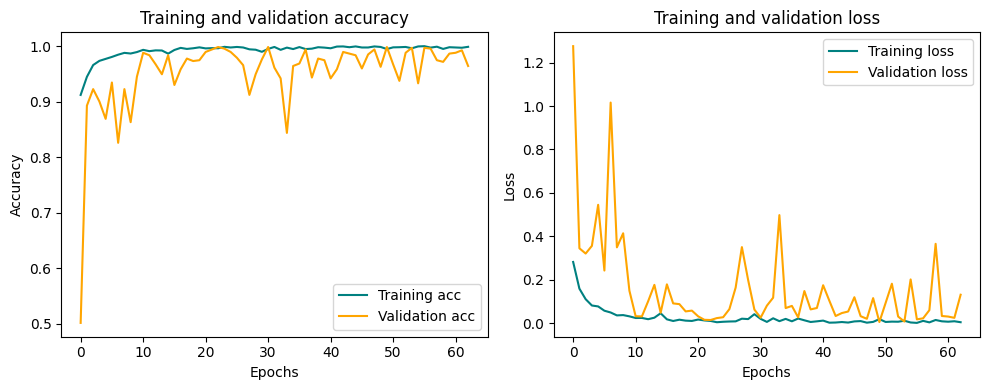

In [18]:
# Vẽ đồ thị training
plot_model_history(model_info)

## 5. Testing

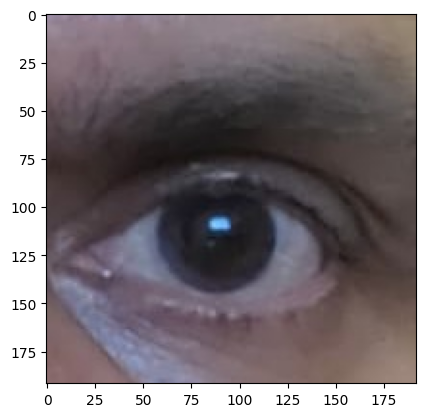

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
[[2.5772604e-09 1.0000000e+00]]
Predicted class: Open Eyes


In [19]:
CLASS_LABELS = {0: "Closed Eyes", 1: "Open Eyes"}

model = tf.keras.models.load_model(model_path)

path = '/kaggle/input/drowsiness-dataset/Dataset/Test/Open_Eyes/_495.jpg'

plt.imshow(mpimg.imread(path))
plt.show()

# Open image, convert to grayscale and resize
img = preprocess_image(path)
x = np.expand_dims(img, axis=0)

y_predict = model.predict(x)
print(y_predict)

# Get the predicted class and label
prediction = int(np.argmax(y_predict))
print("Predicted class:", CLASS_LABELS[prediction])

## 6. Get actual and predicted labels for confusion matrix and classification report

In [20]:
y_test = []
y_pred = []

for i in range(len(test_generator)):
  batch_images, batch_labels = test_generator[i]
  batch_predictions = model.predict(batch_images)
  batch_pred_labels = np.argmax(batch_predictions, axis=1)
  y_test.extend(np.argmax(batch_labels, axis=1))
  y_pred.extend(batch_pred_labels)

y_test = np.array(y_test)
y_pred = np.array(y_pred)
# Check shapes for matching
if len(y_test) != len(y_pred):
    print("Kích thước của y_test và y_pred không khớp. Điều chỉnh số bước (steps) hoặc batch_size.")
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

## 7. Print confusion matrix of model 1

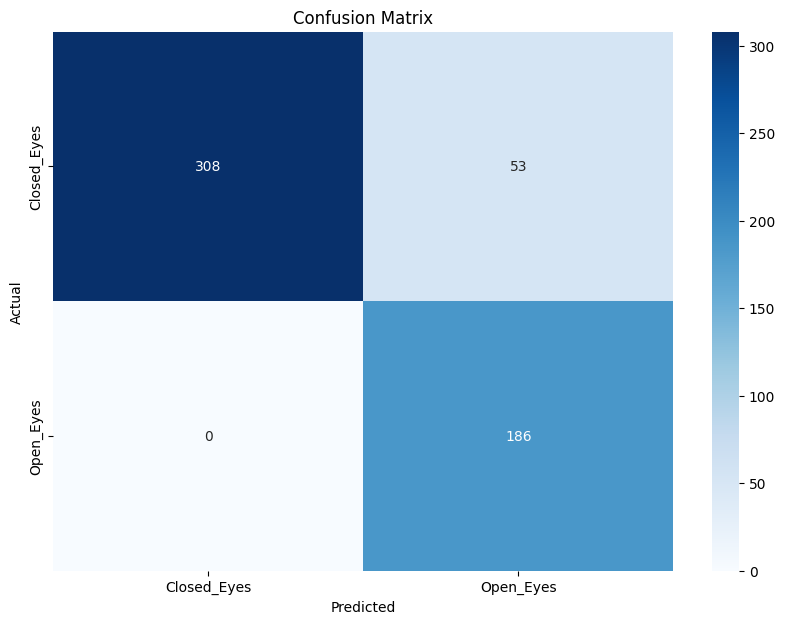

In [21]:
cm = pd.DataFrame(conf_mat, columns=CLASSES, index=CLASSES)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## 8. Print classification report of model 1

In [22]:
print(classification_report(y_test, y_pred, target_names=CLASSES))

              precision    recall  f1-score   support

 Closed_Eyes       1.00      0.85      0.92       361
   Open_Eyes       0.78      1.00      0.88       186

    accuracy                           0.90       547
   macro avg       0.89      0.93      0.90       547
weighted avg       0.92      0.90      0.91       547



# II. Continue using simple CNN to predict for the mouth

## 1. Okay, let's get started!

In [23]:
# Define classes
CLASSES = ['No_yawn', 'Yawn']

# Parameters
num_train = 0  # To be calculated
num_val = 0    # To be calculated
batch_size = 16
num_epoch = 100
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [24]:
# Create Data Generators
train_generator = CustomDataGenerator(train_dir, CLASSES, batch_size, shuffle=True)
validation_generator = CustomDataGenerator(val_dir, CLASSES, batch_size, shuffle=False)
test_generator = CustomDataGenerator(test_dir, CLASSES, batch_size, shuffle=False)

num_train = len(train_generator.image_paths)
num_val = len(validation_generator.image_paths)
num_test = len(test_generator.image_paths)

In [25]:
# Count the number of images in each class for training, testing and validation sets
print("Train images:")
count_images_in_classes(train_dir)

print("\nValidation images:")
count_images_in_classes(val_dir)

print("\nTest images:")
count_images_in_classes(test_dir)

Train images:
Class Yawn: 2150 images
Class No_yawn: 2165 images

Validation images:
Class Yawn: 427 images
Class No_yawn: 455 images

Test images:
Class Yawn: 448 images
Class No_yawn: 469 images


## Model 2 changes the height and width of the input image so the model architecture will have to be redesigned

In [26]:
with tf.device('/device:GPU:0'):
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
    
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
    
        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
    
        # Dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(CLASSES), activation='softmax')
    ])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 67,400,674 (257.11 MB)

 Trainable params: 67,398,754 (257.11 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [28]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

In [29]:
# Callbacks
checkpoint = ModelCheckpoint(
    'simple_CNN_mouth_modelV6_3.keras',  # Changed to .keras
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=40,
    restore_best_weights=True
)

## 2. Compile model 2

In [30]:
# Compile Model
with tf.device('/device:GPU:0'):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy',  # Changed to categorical_crossentropy
                  metrics=['accuracy'])

## 3. Training model

In [31]:
with tf.device('/device:GPU:0'):
    model_info = model.fit(
        train_generator,
        epochs=num_epoch,
        validation_data=validation_generator,
        callbacks=[checkpoint, early_stopping]
    )

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


269/270 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8130 - loss: 0.5777
Epoch 1: val_accuracy improved from -inf to 0.51587, saving model to simple_CNN_mouth_modelV6_3.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - accuracy: 0.8132 - loss: 0.5766 - val_accuracy: 0.5159 - val_loss: 25.7582
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9018 - loss: 0.2658
Epoch 2: val_accuracy improved from 0.51587 to 0.56463, saving model to simple_CNN_mouth_modelV6_3.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.9018 - loss: 0.2658 - val_accuracy: 0.5646 - val_loss: 5.7596
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9195 - loss: 0.2201
Epoch 3: val_accuracy improved from 0.56463 to 0.91383, saving model to simple_CNN_mouth_modelV6_3.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.9196 - loss: 0.2200 - val_accuracy: 0.9138 - val_loss: 0.4325
Epoch 4/100
269/270 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9388 - l

In [32]:
model_path = "simple_CNN_mouth_modelV6_3.keras"
model.save(model_path)

## 4. Plot the training graph of model 2

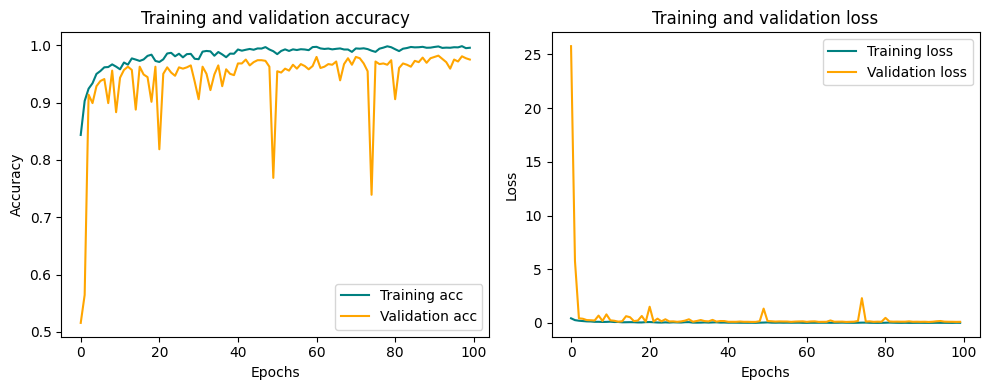

In [33]:
plot_model_history(model_info)

## 5. Testing

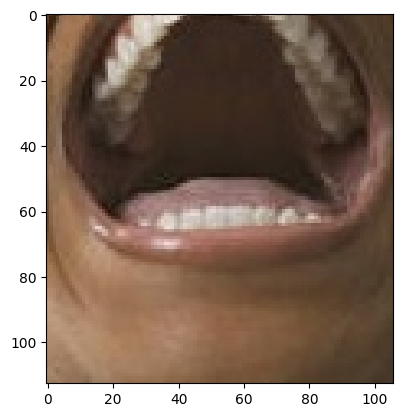

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
[[4.0026896e-07 9.9999964e-01]]
Predicted class: Yawn


In [34]:
CLASS_LABELS = {0: "No Yawn", 1: "Yawn"}

model = tf.keras.models.load_model(model_path)

path = '/kaggle/input/drowsiness-dataset/Dataset/Train/Yawn/1026.jpg'

plt.imshow(mpimg.imread(path))
plt.show()

# Open image, convert to grayscale and resize
img = preprocess_image(path)
x = np.expand_dims(img, axis=0)

y_predict = model.predict(x)
print(y_predict)

# Get the predicted class and label
prediction = int(np.argmax(y_predict))
print("Predicted class:", CLASS_LABELS[prediction])

## 6. Get actual and predicted labels for confusion matrix and classification report

In [35]:
y_test = []
y_pred = []

for i in range(len(test_generator)):
  batch_images, batch_labels = test_generator[i]
  batch_predictions = model.predict(batch_images)
  batch_pred_labels = np.argmax(batch_predictions, axis=1)
  y_test.extend(np.argmax(batch_labels, axis=1))
  y_pred.extend(batch_pred_labels)

y_test = np.array(y_test)
y_pred = np.array(y_pred)
# Check shapes for matching
if len(y_test) != len(y_pred):
    print("Kích thước của y_test và y_pred không khớp. Điều chỉnh số bước (steps) hoặc batch_size.")
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

## 7. Print confusion matrix of model 2

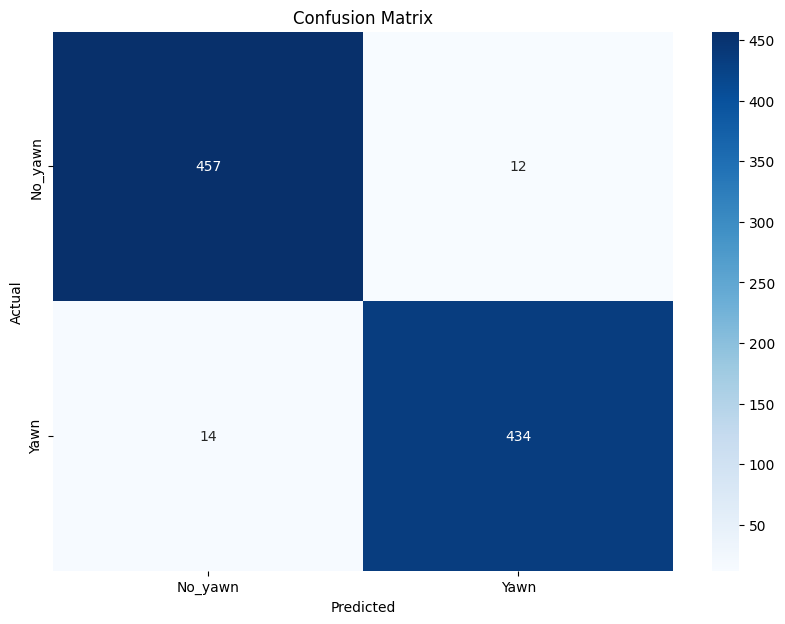

In [36]:
cm = pd.DataFrame(conf_mat, columns=CLASSES, index=CLASSES)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## 8. Print classification report of model 2

In [37]:
print(classification_report(y_test, y_pred, target_names=CLASSES))

              precision    recall  f1-score   support

     No_yawn       0.97      0.97      0.97       469
        Yawn       0.97      0.97      0.97       448

    accuracy                           0.97       917
   macro avg       0.97      0.97      0.97       917
weighted avg       0.97      0.97      0.97       917

